In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#Read Toyota data
data = pd.read_csv('/content/TSLA.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,1.929333,1.966667,1.843333,1.872000,1.872000,13921500
1,2012-01-04,1.880667,1.911333,1.833333,1.847333,1.847333,9451500
2,2012-01-05,1.850667,1.862000,1.790000,1.808000,1.808000,15082500
3,2012-01-06,1.813333,1.852667,1.760667,1.794000,1.794000,14794500
4,2012-01-09,1.800000,1.832667,1.741333,1.816667,1.816667,13455000
...,...,...,...,...,...,...,...
2997,2023-11-30,245.139999,245.220001,236.910004,240.080002,240.080002,132353200
2998,2023-12-01,233.139999,240.190002,231.899994,238.830002,238.830002,121173500
2999,2023-12-04,235.750000,239.369995,233.289993,235.580002,235.580002,104099800
3000,2023-12-05,233.869995,246.660004,233.699997,238.720001,238.720001,137971100


In [3]:
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [4]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.7 MB/s eta 0:00:00


In [5]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4797.793, Time=5.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4809.510, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4809.196, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4809.290, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4809.805, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4800.444, Time=3.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4810.743, Time=2.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4726.950, Time=11.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4783.044, Time=2.49 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4782.869, Time=6.90 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=7.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4726.540, Time=7.85 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4783.707, Time=1.40 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4784.847, Time=4.02 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   :

In [6]:
order = (2, 1, 3)  # ARIMA order
seasonal_order = (0, 0, 0, 0)  # SARIMA order with seasonality
model = SARIMAX(data['Close'], order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)

In [7]:
# Define SARIMA model
import statsmodels.api as sm
p,d,q = 2,1,3
P,D,Q,s = 0,0,0,0

# Fit SARIMA model
model = sm.tsa.statespace.SARIMAX(data['Close'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model.fit()

In [8]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = results.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=True)
# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_val_pred = results.predict(start=val_data.index[0], end=val_data.index[-1], dynamic=True)

In [9]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
# Predict for the next 30 days using SARIMA
forecast_steps = 30
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

# Extract the forecasted values for the next 30 days
y_next_30_days = forecast_mean.values
y_next_30_days

array([240.25230248, 239.67249942, 239.4540862 , 240.18975679,
       239.55526337, 239.63784896, 240.08448029, 239.51658489,
       239.77033517, 239.9696586 , 239.53207776, 239.85054981,
       239.86710422, 239.57827614, 239.88612766, 239.78823014,
       239.63597819, 239.88878017, 239.73628572, 239.69161958,
       239.87086648, 239.70901229, 239.73722492, 239.84319293,
       239.70113691, 239.76949663, 239.81391139, 239.70637372,
       239.78851964, 239.78826381])

In [10]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

test_mae = mean_absolute_error(y_pred, y_test)
test_rmse = np.sqrt(mean_squared_error(y_pred, y_test))
test_mape = mean_absolute_percentage_error(y_pred, y_test)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_val_pred, y_val)
val_rmse = np.sqrt(mean_absolute_error(y_val_pred, y_val))
val_mape = mean_absolute_percentage_error(y_val_pred, y_val)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 177.7609618883635
Testing RMSE: 195.78400941872937
Testing MAPE: 3.2792334262751512
---------------------------
Validation MAE: 66.4029538410025
Validation RMSE: 8.1488007609097
Validation MAPE: 0.2401066593353875


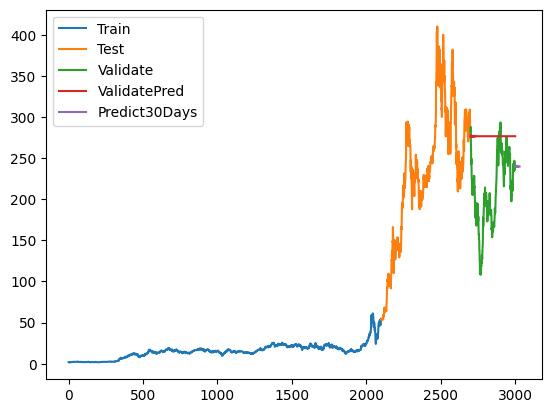

In [11]:
# Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_val_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate','ValidatePred','Predict30Days'])
plt.show()